In [1]:
#pytorchのバージョン確認
import torch
torch.__version__

'1.10.0+cu113'

In [20]:
# パッケージのimport
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.utils.data as data
import torchtext
from torchvision import models, transforms

import glob
import os
import io
import string
from tqdm import tqdm
import random
import re
import MeCab
import clip

In [18]:
#num_data_decide:train,val,testデータの数を出力する関数（defaultは8:1:1）
def num_data_decide():
    num_data = 202520
    train_rate, val_rate, test_rate = [8,1,1]
    total = train_rate + val_rate + test_rate
    train = int(num_data*(train_rate/total)//5*5)
    val = int(num_data*(val_rate/total)//5*5)
    test = num_data - train - val
    return train, val, test

In [17]:
#Datasetクラス作成時に利用するtsvファイルを作成しています。

#image_listに画像のpathを格納
path = "./data/caption_val.txt"

train_num, val_num, test_num = num_data_decide()
#train、val、testデータ数の確認
print(f"trainデータ:{train_num}, valデータ:{val_num}, testデータ:{test_num}")

f2 = open(path,"r")
datalist=f2.readlines()
f2.close()

#学習用データのtsvファイルを作成
f = open("./data/train.tsv","w")

image_list = []
image_number = -1
for line in tqdm(datalist[:train_num]):
    tokens = line.split()
    image = tokens[0]
    caption = tokens[1:]
    caption = "".join(caption)
    if image not in image_list:
        image_list.append(image)
        image_number += 1
    text = caption+'\t'+str(image_number)+'\t'+'\n'
    f.write(text)

f.close()

#評価用データのtsvファイルを作成
f = open("./data/val.tsv","w")

for line in tqdm(datalist[train_num:train_num+val_num]):
    tokens = line.split()
    image = tokens[0]
    caption = tokens[1:]
    caption = "".join(caption)
    if image not in image_list:
        image_list.append(image)
        image_number += 1
    text = caption+'\t'+str(image_number)+'\t'+'\n'
    f.write(text)

f.close()

#テストデータのtsvファイルを作成
f = open("./data/test.tsv","w")

for line in tqdm(datalist[train_num+val_num:]):
    tokens = line.split()
    image = tokens[0]
    caption = tokens[1:]
    caption = "".join(caption)
    if image not in image_list:
        image_list.append(image)
        image_number += 1
    text = caption+'\t'+str(image_number)+'\t'+'\n'
    f.write(text)

f.close()

trainデータ:162015, valデータ:20250, testデータ:20255


100%|███████████████████████████████████| 20255/20255 [00:11<00:00, 1789.40it/s]


In [16]:
#image_listからimageを開き、tensorに変換し、image_tensor_listに格納
# 入力画像の前処理のクラス
class BaseTransform():
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換(0～255の値を0～1になるように調整)
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)

image_tensor_list = []

# 画像読み込み&前処理後の画像をtensor化し、image_tensor_listに格納
count=0
for image in tqdm(image_list):
    image_file_path = "./data/val2014/"+ image
    img = Image.open(image_file_path)# [高さ][幅][色RGB]
    if img.mode != "RGB":
        img = img.convert("RGB")
    img_transformed = transform(img)
    image_tensor_list.append(img_transformed)

100%|████████████████████████████████████| 40504/40504 [05:32<00:00, 121.92it/s]


torch.Size([3, 224, 224])


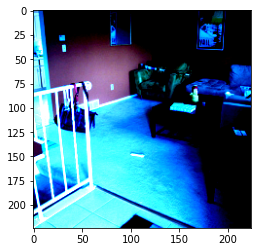

In [6]:
# 前処理後の画像を確認できます（実行しなくても以降のプログラムは動きます）
# img_number:0 ~ 40503
img_number = 0
print(image_tensor_list[img_number].size())

img_trans = image_tensor_list[img_number].numpy().transpose((1, 2, 0))
img_trans = np.clip(img_trans, 0, 1)
plt.imshow(img_trans)
plt.show()

In [30]:
# テキストの前処理を行い、単語分割を行う関数を定義
# MeCabと呼ばれる、単語分割（形態素解析）のライブラリを使用して、単語分割を行う。
# ここでエラーが出た場合、Mecab.Tagger内のpathの指定が間違っている可能性があります。NEologdが入っているPathを指定してください。
m_t = MeCab.Tagger('mecab -Owakati -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')

#tokenizer_mecab:文章を入力として受け取り、文章を単語単位に分割したリストを返す関数
def tokenizer_mecab(text):
    text = m_t.parse(text)  # これでスペースで単語が区切られる
    ret = text.strip().split()  # スペース部分で区切ったリストに変換
    return ret

#preprocessing_text:テキストの前処理を行う関数
def preprocessing_text(text):
    text = text.replace('"',"")
    text = re.sub("\r","",text)
    text = re.sub("\n","",text)
    text = re.sub("　","",text)
    text = re.sub(" ","",text)
    text = text.translate(str.maketrans({'０':'O','１':'1','２':'2','３':'3','４':'4','５':'5',
                                         '６':'6','７':'7','８':'8','９':'9'}))
    return text

#tokenizer_with_preprocessing:テキストの前処理を行い、単語分割を行う関数
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_mecab(text)
    return ret

In [31]:
# 動作確認(実行しなくても、プログラムは動きます)
text = "昨日は 旭山動物園に３3人で行ったが、キリンが153５頭いるだけだった。"
print(tokenizer_with_preprocessing(text))

['昨日', 'は', '旭山動物園', 'に', '33人', 'で', '行っ', 'た', 'が', '、', 'キリン', 'が', '1535', '頭', 'いる', 'だけ', 'だっ', 'た', '。']


In [32]:
#Datasetクラス作成時に、データ(文章とラベル)にどのような処理を施すか定義している。
max_length = 25 #詳しい説明は省きますが、decoderの入力と出力で1文字ずらすので想定の+1しています。デフォルトでは最長で24単語のキャプションが扱えるように、25に設定しています。
TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing, use_vocab=True,
                                  lower=True, include_lengths=True, batch_first=True, fix_length=max_length,
                                  init_token="<bos>",eos_token="<eos>")
LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

In [34]:
#datasetの作成
train_ds, val_ds, test_ds = torchtext.legacy.data.TabularDataset.splits(path="./data/",train="train.tsv",test="test.tsv",validation="val.tsv",
                                                                        format="tsv",fields=[("Text",TEXT),("Label",LABEL)])

print(f"学習用データ数：{len(train_ds)}")
print(f"評価用データ数：{len(val_ds)}")
print(f"テスト用データ数：{len(test_ds)}")

学習用データ数：162015
評価用データ数：20250
テスト用データ数：20255


In [36]:
from torchtext.vocab import Vectors

japanese_fasttext_vectors = Vectors(name="./data/vector_neologd/model.vec")

print("1単語を表現する次元数：",japanese_fasttext_vectors.dim)
print("単語数：",len(japanese_fasttext_vectors.itos))

1単語を表現する次元数： 300
単語数： 2000000


In [39]:
#ベクトル化したバージョンのボキャブラリーを作成
#学習用データ内に10回以上登場する単語のみで辞書を作成
TEXT.build_vocab(train_ds, vectors=japanese_fasttext_vectors, min_freq=10)

print(TEXT.vocab.vectors.shape)
token_num = TEXT.vocab.vectors.shape[0]
print(f"単語数：{token_num}")

#number_dict:keyがID、valueが単語のdict
number_dict = {i: w for i, w in enumerate(TEXT.vocab.stoi)}

torch.Size([5344, 300])
単語数：5344


In [42]:
# Dataloaderの作成
train_dl = torchtext.legacy.data.Iterator(train_ds, batch_size=16, train=True)
val_dl = torchtext.legacy.data.Iterator(val_ds, batch_size=5, train=False, sort=False)
test_dl = torchtext.legacy.data.Iterator(test_ds,batch_size=5,train=True)

dataloaders_dict = {"train":train_dl,"val":val_dl,"test":test_dl}

In [50]:
# clipモデルのロード
device = "cuda:0" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load('ViT-B/16', device=device)

In [51]:
#self.dropout = nn.Dropout(dropout)　を追加する
#n_position:文章の長さ(文章を構成する単語の数)
def get_sinusoid_encoding_table(n_position, d_model):
    #position:その単語が文中の何番目にあるか、hid_idx:単語の分散ベクトルの何次元めか
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

#seq_q:[batch_size x source_len](文の各単語のIDが文章の順に格納されたtensor)
def get_attn_pad_mask(seq_k):
    #torch.eq(input,other)でotherと値が等しい要素はTrueに、そうでない要素はFalseの配列を返す
    pad_attn_mask = seq_k.data.eq(TEXT.vocab.stoi["<pad>"])
    return pad_attn_mask  # batch_size x len_k 

#seq:[batch_size x source_len]
#[source_len x source_len]サイズで、上三角の要素(対角上除く)がすべてTrueの行列を返す
def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).bool()
    return subsequent_mask

#d_model,max_length
#ResNeXt101_32x8d(出力層の特徴利用)
#defaultでrequires_grad = True
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(512, (max_length-1)*d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, enc_inputs):
        enc_outputs = clip_model.encode_image(enc_inputs).to(torch.float)
        #enc_outputs = self.clip_enc(enc_inputs ,return_dict=False)
        enc_outputs = self.linear(enc_outputs).view(-1, max_length-1, d_model)
        enc_outputs = self.layer_norm(enc_outputs)   
        return enc_outputs

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding.from_pretrained(embeddings=TEXT.vocab.vectors, freeze=True)
        self.pos_emb = get_sinusoid_encoding_table(tgt_len, d_model).unsqueeze(0)
        self.dropout = nn.Dropout(dropout)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=300,nhead=6,batch_first=True)
        self.layers = nn.TransformerDecoder(self.decoder_layer,num_layers=12)
        
    def forward(self, dec_inputs, enc_outputs):
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb.expand(dec_inputs.size(0),self.pos_emb.size(1),self.pos_emb.size(2)).to(device)
        dec_outputs = self.dropout(dec_outputs)

        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs).to(device)
        dec_pad_mask = get_attn_pad_mask(dec_inputs)
        dec_outputs = self.layers(dec_outputs,enc_outputs,tgt_mask=dec_self_attn_subsequent_mask,tgt_key_padding_mask=dec_pad_mask)
        
        return dec_outputs
        
        
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model,tgt_vocab_size,bias=False)
        #self.projection.weight = nn.Parameter(self.decoder.tgt_emb.weight,requires_grad=False)
        
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs = self.encoder(enc_inputs)
        dec_outputs = self.decoder(dec_inputs, enc_outputs)
        # dec_logits : [batch_size x target_len x tgt_vocab_size] 
        dec_logits = self.projection(dec_outputs)
        return dec_logits.view(-1, dec_logits.size(-1))

## Beam Searchを行うための関数を定義

In [52]:
#入力が１つの画像で、1つのキャプションを出力するもの
#enc_input：batch_size = 1　とする
#start_symbol：<bos>の単語ID(今は2)

#dec_input:Decoderに入れるベクトル([batch_size=1 x tgt_len])
#i:何単語目の予測結果を得るか(0以上)
#softmax:softmax関数
#beam_sizeの数だけ確率の大きい順に、単語idとその確率を格納したtensorを返す
def beam_search(model, dec_input, enc_outputs, beam_size, softmax, i):
    dec_outputs = model.decoder(dec_input, enc_outputs)
    #projected ：[batch_size x target_len x tgt_vocab_size] 
    projected = model.projection(dec_outputs)
    prob_list = softmax(projected)
    rank_list = torch.topk(prob_list, beam_size)
    #prob_listに定数(100とか)をかけると結果がなぜか変わってくる
    prob_list = rank_list[0][0][i]
    ids = rank_list[1][0][i]
    id_list = torch.tensor([],dtype=torch.long).to(device)
    for time in range(beam_size):
        dec_input[0][i+1] = ids[time].item() 
        id_list = torch.cat((id_list,dec_input))
    return prob_list, id_list


def length_penalty(alpha,length_tensor):
    return (5+length_tensor)**alpha/6**alpha


def beam_search_decoder(model, enc_input, start_symbol, beam_size):
    end_symbol = 3
    id_list_com = torch.tensor([],dtype=torch.long).to(device)
    prob_list_com = torch.zeros(beam_size)
    length_list = torch.zeros(beam_size)
    softmax = nn.Softmax(dim = -1)
    enc_outputs = model.encoder(enc_input)
    #　<pad>の単語IDが1なので、torch.onesをつかっている。
    dec_input = torch.ones(1,max_length-1,dtype=torch.long).to(device)
    next_symbol = start_symbol
    dec_input[0][0] = next_symbol
    prob_list,id_list = beam_search(model, dec_input, enc_outputs, beam_size, softmax, 0)
    #ここまでで、1単語目のbeam searchが終了
    count=0
    for i in range(1,tgt_len-1):
        prob_list2 = torch.tensor([]).to(device)
        id_list2 = torch.tensor([],dtype=torch.long).to(device)
        for j in range(beam_size-count):
            prob_list3, id_list3 = beam_search(model,id_list[j].unsqueeze(0), enc_outputs, beam_size-count, softmax, i)
            prob_list2 = torch.cat((prob_list2, prob_list3*prob_list[j].item()))
            id_list2 = torch.cat((id_list2,id_list3.squeeze(0)))
        prob_list = torch.topk(prob_list2,beam_size-count)[0]
        id_list = torch.tensor([],dtype=torch.long).to(device)
        if beam_size-count == 1:
            id_list = id_list2.unsqueeze(0)
        else:
            for key in torch.topk(prob_list2,beam_size-count)[1]:
                id_list = torch.cat((id_list,id_list2[key.item()].unsqueeze(0)))
        #ここからlength_penaltyを導入するためのプログラム
        for k in range(len(id_list)):
            if id_list[k][i+1]==end_symbol:
                id_list_com = torch.cat((id_list_com,id_list[k].unsqueeze(0)))
                prob_list_com[count] = prob_list[k]
                length_list[count]=i
                count += 1
            elif i==tgt_len-2:
                id_list_com = torch.cat((id_list_com,id_list[k].unsqueeze(0)))
                prob_list_com[count] = prob_list[k]
                length_list[count]=i+1
                count += 1
        prob_list = prob_list[id_list[:,i+1]!=end_symbol]
        id_list = id_list[id_list[:,i+1]!=end_symbol]
        if count == beam_size:
            break
            
    prob_list_com = torch.log(prob_list_com)/length_penalty(0.6,length_list)
    caption = id_list_com[torch.topk(prob_list_com,1)[1]].squeeze()
    
    return caption

## 評価指標の定義（BLEU と ROUGE）

In [53]:
#評価指標BLEU
from ignite.metrics.nlp import Bleu

m = Bleu(ngram=4, smooth="smooth1")

result = ['道路', 'を','車', 'が', '走っ', 'て', 'いる']
answers = [["今日","は","晴れ","て","いて","とても","天気","が","良い"], 
           ['2', '台', 'の', '車', 'が', '道路', 'に', '停', 'まっ', 'て', 'いる'],
          ["自転車","の","横","で","白い","犬","が","横","に","なっ","て","いる"]]

m.update(([result], [answers]))
a = m.compute()
print(a)

#学習中のBleuの計算を行うための関数
def val_bleu(val_result,answers):
    m = Bleu(ngram=4, smooth="smooth1")
    m.reset()
    m.update(([val_result], [answers]))
    a = m.compute()
    return a.item()

#動作確認
result = ["今日","は","天気","が","良い"]
answers = [["今日","は","晴れ","て","いて","とても","天気","が","良い"], 
           ["白い","靴","や","赤","や","黒","の","草履","が","乱雑","に","置か","れ","た","棚"],
          ["自転車","の","横","で","白い","犬","が","横","に","なっ","て","いる"]]

val_bleu(result,answers)

tensor(0.0785, dtype=torch.float64)


0.1502421942492453

In [54]:
#評価指標ROUGE
from ignite.metrics import Rouge
#alpha:recallとprecisionの割合
m = Rouge(variants=["L", 2], multiref="best",alpha=0.5)

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

m.compute()
# {'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-2-P': 0.5, 'Rouge-2-R': 0.4,
# 'Rouge-2-F': 0.4}

#Rouge(準公式)の動作確認
m = Rouge(variants=["L",1], multiref="best",alpha=0.5)
result = ['道路', 'を','車', 'が', '走っ', 'て', 'いる']
answers = [["今日","は","晴れ","て","いて","とても","天気","が","良い"], 
           ['2', '台', 'の', '車', 'が', '道路', 'に', '停', 'まっ', 'て', 'いる'],
          ["自転車","の","横","で","白い","犬","が","横","に","なっ","て","いる"]]

m.update(([result], [answers]))
a = m.compute()
print(a)

#学習中のRougeの計算を行うための関数
def val_rouge_new(val_result,answers):
    m = Rouge(variants=["L"], multiref="best",alpha=0.5)
    m.reset()
    m.update(([val_result], [answers]))
    a = m.compute()
    return a["Rouge-L-F"]

#動作確認
result = ["今日","は","天気","が","良い"]
answers = [["今日","は","晴れ","て","いて","とても","天気","が","良い"], 
           ["白い","靴","や","赤","や","黒","の","草履","が","乱雑","に","置か","れ","た","棚"],
          ["自転車","の","横","で","白い","犬","が","横","に","なっ","て","いる"]]

val_rouge_new(result,answers)

{'Rouge-L-P': 0.5714285714285714, 'Rouge-L-R': 0.36363636363636365, 'Rouge-L-F': 0.4444444444444444, 'Rouge-1-P': 0.7142857142857143, 'Rouge-1-R': 0.45454545454545453, 'Rouge-1-F': 0.5555555555555556}


0.7142857142857143

In [62]:
#Transformerの学習
#約10分かかる

d_model=300
tgt_vocab_size = TEXT.vocab.vectors.shape[0]
tgt_len = max_length-1
n_layers = 6
n_heads = 6
d_k = d_v = 50
d_ff = 2048 #FeedForward dimension
batch_size = 16
dropout = 0.1

#各エポックにおける評価を格納
val_loss = []
bleu_loss =[]
val_high_score = 0
bleu_high_score = 0

net = Transformer()
print("ネットワーク設定完了")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：",device)
print("------start------")
net.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#計算を最適化してくれるらしい
torch.backends.cudnn.benchmark = True

num_epochs = 10


for epoch in range(num_epochs):
    for phase in ["train","val"]:
        if phase == "train":
            net.train()
            epoch_loss = 0.0
            for batch in tqdm(dataloaders_dict[phase]):
                x = batch.Label
                inputs=torch.tensor([])
                for i in x:
                    one = image_tensor_list[i].unsqueeze(0)
                    inputs = torch.cat((inputs,one))
                inputs = inputs.to(device)
                
                de_inputs = batch.Text[0][:,:-1].to(device)
                labels = batch.Text[0][:,1:].to(device)
                
                optimizer.zero_grad()
                outputs = net(inputs, de_inputs)
                loss = criterion(outputs, labels.contiguous().view(-1))
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item() * batch_size
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            print("Epoch {}/{} | {:^5} | Loss:{:.4f}".format(epoch+1,num_epochs,phase,epoch_loss))
                    
        else:
            net.eval()
            #val_dlのbatch_size=5の時のみ適用可
            val_score = 0
            bleu_score = 0
            #もし、最初の方のエポックは評価をskipしたかったら、epoch>=0の0を変える
            if epoch>=0:
                for batch in tqdm(dataloaders_dict[phase]):
                    x = batch.Label[0]
                    inputs = image_tensor_list[x].unsqueeze(0).to(device)
                    start_token = 2
                    val_result = beam_search_decoder(net, inputs, start_token, 1)[1:]
                    result_sen = []
                    for word in val_result:
                        if word!=TEXT.vocab.stoi["<eos>"]:
                        #if word!=3:
                            result_sen.append(number_dict[word.item()])
                        else:
                            break
                    labels = batch.Text[0][:,1:]
                    answers=[]
                    for answer in labels:
                        ans_list = []
                        for word in answer:
                            if word != TEXT.vocab.stoi["<eos>"]:
                                ans_list.append(number_dict[word.item()])
                            else:
                                break
                        answers.append(ans_list)
                    # rougeでの評価
                    rouge = val_rouge_new(result_sen, answers)
                    val_score += rouge
                    #bleuでの評価
                    bleu = val_bleu(result_sen, answers)
                    bleu_score += bleu
                    
                val_score /= len(dataloaders_dict[phase])
                val_loss.append(val_score)
                bleu_score /= len(dataloaders_dict[phase])
                bleu_loss.append(bleu_score)
                if val_score>val_high_score and bleu_score>bleu_high_score:
                    val_high_score = val_score
                    bleu_high_score = bleu_score
                    #ネットワークを保存する
                    torch.save(net.state_dict(), "best_net.ckpt")
                print("ROUGE-L:{:.4f}".format(val_score))
                print("BLEU:{:.4f}".format(bleu_score))
                

ネットワーク設定完了
使用デバイス： cuda:0
------start------


  1%|▍                                       | 99/10126 [00:14<24:46,  6.75it/s]


KeyboardInterrupt: 

## 評価指標のコード作成

### ROUGE-L

In [56]:
#最も評価の高かったモデルの読み込み
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
d_model=300
tgt_vocab_size = TEXT.vocab.vectors.shape[0]
tgt_len = max_length-1
n_layers = 6
n_heads = 6
d_k = d_v = 50
d_ff = 2048 #FeedForward dimension
batch_size = 16
dropout = 0.1
net_best = Transformer().to(device)
net_best.load_state_dict(torch.load("best_net.ckpt"))
net_best.eval()

RuntimeError: Error(s) in loading state_dict for Transformer:
	size mismatch for encoder.linear.weight: copying a param with shape torch.Size([9600, 512]) from checkpoint, the shape in current model is torch.Size([7200, 512]).
	size mismatch for encoder.linear.bias: copying a param with shape torch.Size([9600]) from checkpoint, the shape in current model is torch.Size([7200]).

In [33]:
test_dl = torchtext.legacy.data.Iterator(test_ds,batch_size=5,train=True)

cuda:0
tensor(37244)


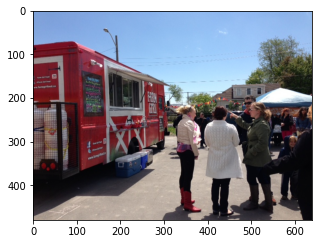

sentence: ['<bos>', '赤い', '服', 'を', '着', 'た', '女性', 'が', 'たくさん', 'に', '乗っ', 'て', 'いる', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
sentence: ['<unk>', '赤い', '服', 'を', '着', 'た', '女性', 'が', 'たくさん', 'に', '乗っ', 'て', 'いる', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [40]:
#推論(beam search)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net_best2.eval()
net_best2.to(device)

#times:推論結果を出力する回数(最大でbatch_size)
times = 1
beam_size = 6
count = 0
for batch in test_dl:
    x = batch.Label[0]
    img_num = x
    print(img_num)
    enc_input = image_tensor_list[img_num].unsqueeze(0).to(device)
    #start_token = random.choice([TEXT.vocab.stoi["<bos>"],TEXT.vocab.stoi["<bos2>"]])
    start_token = TEXT.vocab.stoi["<bos>"]
    result = beam_search_decoder(net_best2, enc_input, start_token, beam_size)
    ori_img = Image.open("./data/val2014/"+image_list[img_num])
    img_trans = image_tensor_list[img_num].numpy().transpose((1, 2, 0))
    img_trans = np.clip(img_trans, 0, 1)
    plt.figure(figsize=(5,5))
    plt.imshow(ori_img)
    plt.show()

    print("sentence:",[number_dict[word.item()] for word in result])
    
    count+=1
    if count>=times:
        break